In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unified-mnist-fashion-mnist-quickdraw-dataset/unified_dataset/mnist_x_test.npy
/kaggle/input/unified-mnist-fashion-mnist-quickdraw-dataset/unified_dataset/mnist_y_train.npy
/kaggle/input/unified-mnist-fashion-mnist-quickdraw-dataset/unified_dataset/fashion_y_train.npy
/kaggle/input/unified-mnist-fashion-mnist-quickdraw-dataset/unified_dataset/categories.txt
/kaggle/input/unified-mnist-fashion-mnist-quickdraw-dataset/unified_dataset/quickdraw_classes.txt
/kaggle/input/unified-mnist-fashion-mnist-quickdraw-dataset/unified_dataset/fashion_x_train.npy
/kaggle/input/unified-mnist-fashion-mnist-quickdraw-dataset/unified_dataset/fashion_y_test.npy
/kaggle/input/unified-mnist-fashion-mnist-quickdraw-dataset/unified_dataset/fashion_x_test.npy
/kaggle/input/unified-mnist-fashion-mnist-quickdraw-dataset/unified_dataset/mnist_y_test.npy
/kaggle/input/unified-mnist-fashion-mnist-quickdraw-dataset/unified_dataset/mnist_x_train.npy
/kaggle/input/unified-mnist-fashion-mnist-quickdraw-dat

In [2]:
# Essential imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-10-01 16:36:28.054026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759336588.296063      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759336588.370940      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# Define dataset path (adjust this to match your dataset name)
dataset_path = "/kaggle/input/unified-mnist-fashion-mnist-quickdraw-dataset/unified_dataset/"

def load_unified_dataset():
    """Load the complete pre-prepared unified dataset"""
    print("Loading unified dataset...")
    
    # Load MNIST
    print("Loading MNIST data...")
    x_mnist_train = np.load(f"{dataset_path}mnist_x_train.npy")
    y_mnist_train = np.load(f"{dataset_path}mnist_y_train.npy")
    x_mnist_test = np.load(f"{dataset_path}mnist_x_test.npy")
    y_mnist_test = np.load(f"{dataset_path}mnist_y_test.npy")
    
    # Load Fashion-MNIST
    print("Loading Fashion-MNIST data...")
    x_fashion_train = np.load(f"{dataset_path}fashion_x_train.npy")
    y_fashion_train = np.load(f"{dataset_path}fashion_y_train.npy")
    x_fashion_test = np.load(f"{dataset_path}fashion_x_test.npy")
    y_fashion_test = np.load(f"{dataset_path}fashion_y_test.npy")
    
    # Load QuickDraw classes
    print("Loading QuickDraw classes...")
    with open(f"{dataset_path}quickdraw_classes.txt", 'r') as f:
        quickdraw_classes = [line.strip() for line in f.readlines()]
    
    # Load QuickDraw data
    print("Loading QuickDraw data...")
    quickdraw_data = []
    quickdraw_labels = []
    
    quickdraw_path = f"{dataset_path}quickdraw/"
    loaded_classes = []
    
    for i, class_name in enumerate(quickdraw_classes):
        file_path = f"{quickdraw_path}{class_name}.npy"
        if os.path.exists(file_path):
            try:
                data = np.load(file_path)
                labels = np.full(len(data), i)
                quickdraw_data.append(data)
                quickdraw_labels.append(labels)
                loaded_classes.append(class_name)
                
                if (i + 1) % 50 == 0:  # Progress indicator
                    print(f"  Loaded {i + 1}/{len(quickdraw_classes)} classes")
                    
            except Exception as e:
                print(f"  Error loading {class_name}: {e}")
                continue
    
    # Combine QuickDraw data
    if quickdraw_data:
        x_quickdraw = np.concatenate(quickdraw_data, axis=0)
        y_quickdraw = np.concatenate(quickdraw_labels, axis=0)
    else:
        x_quickdraw = np.array([])
        y_quickdraw = np.array([])
    
    print(f"\nDataset loading complete!")
    print(f"MNIST: {x_mnist_train.shape[0] + x_mnist_test.shape[0]} samples")
    print(f"Fashion-MNIST: {x_fashion_train.shape[0] + x_fashion_test.shape[0]} samples")
    print(f"QuickDraw: {x_quickdraw.shape[0]} samples from {len(loaded_classes)} classes")
    
    return (x_mnist_train, y_mnist_train, x_mnist_test, y_mnist_test,
            x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test,
            x_quickdraw, y_quickdraw, loaded_classes)

# Load all datasets
(x_mnist_train, y_mnist_train, x_mnist_test, y_mnist_test,
 x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test,
 x_quickdraw, y_quickdraw, quickdraw_classes) = load_unified_dataset()

Loading unified dataset...
Loading MNIST data...
Loading Fashion-MNIST data...
Loading QuickDraw classes...
Loading QuickDraw data...
  Loaded 50/345 classes
  Loaded 100/345 classes
  Loaded 150/345 classes
  Loaded 200/345 classes
  Loaded 250/345 classes
  Loaded 300/345 classes

Dataset loading complete!
MNIST: 70000 samples
Fashion-MNIST: 70000 samples
QuickDraw: 690000 samples from 345 classes


In [4]:
# Define class names for each dataset
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
fashion_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def combine_all_datasets():
    """Combine all three datasets into one unified dataset"""
    print("Combining all datasets...")
    
    # Combine MNIST train and test
    x_mnist_all = np.concatenate([x_mnist_train, x_mnist_test], axis=0)
    y_mnist_all = np.concatenate([y_mnist_train, y_mnist_test], axis=0)
    
    # Combine Fashion-MNIST train and test
    x_fashion_all = np.concatenate([x_fashion_train, x_fashion_test], axis=0)
    y_fashion_all = np.concatenate([y_fashion_train, y_fashion_test], axis=0)
    
    # Adjust labels to prevent conflicts
    print("Adjusting class labels...")
    y_mnist_adjusted = y_mnist_all  # Classes 0-9
    y_fashion_adjusted = y_fashion_all + 10  # Classes 10-19
    y_quickdraw_adjusted = y_quickdraw + 20  # Classes 20+ (20 to 20+num_quickdraw_classes-1)
    
    # Reshape QuickDraw data from (784,) to (28, 28)
    print("Reshaping data...")
    x_quickdraw_reshaped = x_quickdraw.reshape(-1, 28, 28)
    
    # Combine all datasets
    x_combined = np.concatenate([
        x_mnist_all,
        x_fashion_all,
        x_quickdraw_reshaped
    ], axis=0)
    
    y_combined = np.concatenate([
        y_mnist_adjusted,
        y_fashion_adjusted,
        y_quickdraw_adjusted
    ], axis=0)
    
    # Create unified class names list
    all_class_names = mnist_classes + fashion_classes + quickdraw_classes
    num_classes = len(all_class_names)
    
    print(f"\nCombined dataset statistics:")
    print(f"Total samples: {x_combined.shape[0]:,}")
    print(f"Total classes: {num_classes}")
    print(f"Image shape: {x_combined.shape[1:]}")
    print(f"Label range: {y_combined.min()} to {y_combined.max()}")
    
    # Dataset distribution
    unique, counts = np.unique(y_combined, return_counts=True)
    print(f"\nDataset distribution:")
    print(f"MNIST (0-9): {counts[:10].sum():,} samples")
    print(f"Fashion-MNIST (10-19): {counts[10:20].sum():,} samples")
    print(f"QuickDraw (20+): {counts[20:].sum():,} samples")
    
    return x_combined, y_combined, all_class_names, num_classes

# Combine all datasets
x_all, y_all, all_class_names, num_classes = combine_all_datasets()

Combining all datasets...
Adjusting class labels...
Reshaping data...

Combined dataset statistics:
Total samples: 830,000
Total classes: 365
Image shape: (28, 28)
Label range: 0 to 364

Dataset distribution:
MNIST (0-9): 70,000 samples
Fashion-MNIST (10-19): 70,000 samples
QuickDraw (20+): 690,000 samples


In [5]:
def preprocess_data(x_data, y_data, num_classes):
    """Preprocess the combined dataset"""
    print("Preprocessing data...")
    
    # Normalize pixel values to [0, 1]
    x_processed = x_data.astype('float32') / 255.0
    
    # Add channel dimension for CNN (28, 28, 1)
    x_processed = x_processed.reshape(-1, 28, 28, 1)
    
    # Convert labels to categorical (one-hot encoding)
    y_processed = tf.keras.utils.to_categorical(y_data, num_classes)
    
    print(f"Processed data shape: {x_processed.shape}")
    print(f"Processed labels shape: {y_processed.shape}")
    print(f"Data type: {x_processed.dtype}")
    print(f"Value range: [{x_processed.min():.3f}, {x_processed.max():.3f}]")
    
    return x_processed, y_processed

# Preprocess the data
x_processed, y_processed = preprocess_data(x_all, y_all, num_classes)

Preprocessing data...
Processed data shape: (830000, 28, 28, 1)
Processed labels shape: (830000, 365)
Data type: float32
Value range: [0.000, 1.000]


In [6]:
def create_train_val_split(x_data, y_data, test_size=0.2, random_state=42):
    """Create stratified train-validation split"""
    print("Creating train-validation split...")
    
    # Convert one-hot back to labels for stratification
    y_labels = np.argmax(y_data, axis=1)
    
    # Stratified split to maintain class distribution
    x_train, x_val, y_train, y_val = train_test_split(
        x_data, y_data,
        test_size=test_size,
        random_state=random_state,
        stratify=y_labels
    )
    
    print(f"Training set: {x_train.shape[0]:,} samples ({(1-test_size)*100:.0f}%)")
    print(f"Validation set: {x_val.shape[0]:,} samples ({test_size*100:.0f}%)")
    
    return x_train, x_val, y_train, y_val

# Create train-validation split
x_train, x_val, y_train, y_val = create_train_val_split(x_processed, y_processed)

Creating train-validation split...
Training set: 664,000 samples (80%)
Validation set: 166,000 samples (20%)


In [7]:
def compute_class_weights(y_train):
    """Compute class weights to handle imbalanced datasets"""
    print("Computing class weights for balanced training...")
    
    # Get class labels from one-hot encoded labels
    y_labels = np.argmax(y_train, axis=1)
    
    # Compute class weights
    classes = np.unique(y_labels)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_labels
    )
    
    # Convert to dictionary
    class_weight_dict = dict(zip(classes, class_weights))
    
    print(f"Class weights computed for {len(class_weight_dict)} classes")
    print("Sample weights (first 10 classes):")
    for i in range(min(10, len(class_weight_dict))):
        print(f"  Class {i}: {class_weight_dict[i]:.3f}")
    
    return class_weight_dict

# Compute class weights
class_weights = compute_class_weights(y_train)

Computing class weights for balanced training...
Class weights computed for 365 classes
Sample weights (first 10 classes):
  Class 0: 0.329
  Class 1: 0.289
  Class 2: 0.325
  Class 3: 0.318
  Class 4: 0.333
  Class 5: 0.360
  Class 6: 0.331
  Class 7: 0.312
  Class 8: 0.333
  Class 9: 0.327


Visualizing dataset samples...
Finding MNIST samples...
Finding Fashion-MNIST samples...
Finding QuickDraw samples...


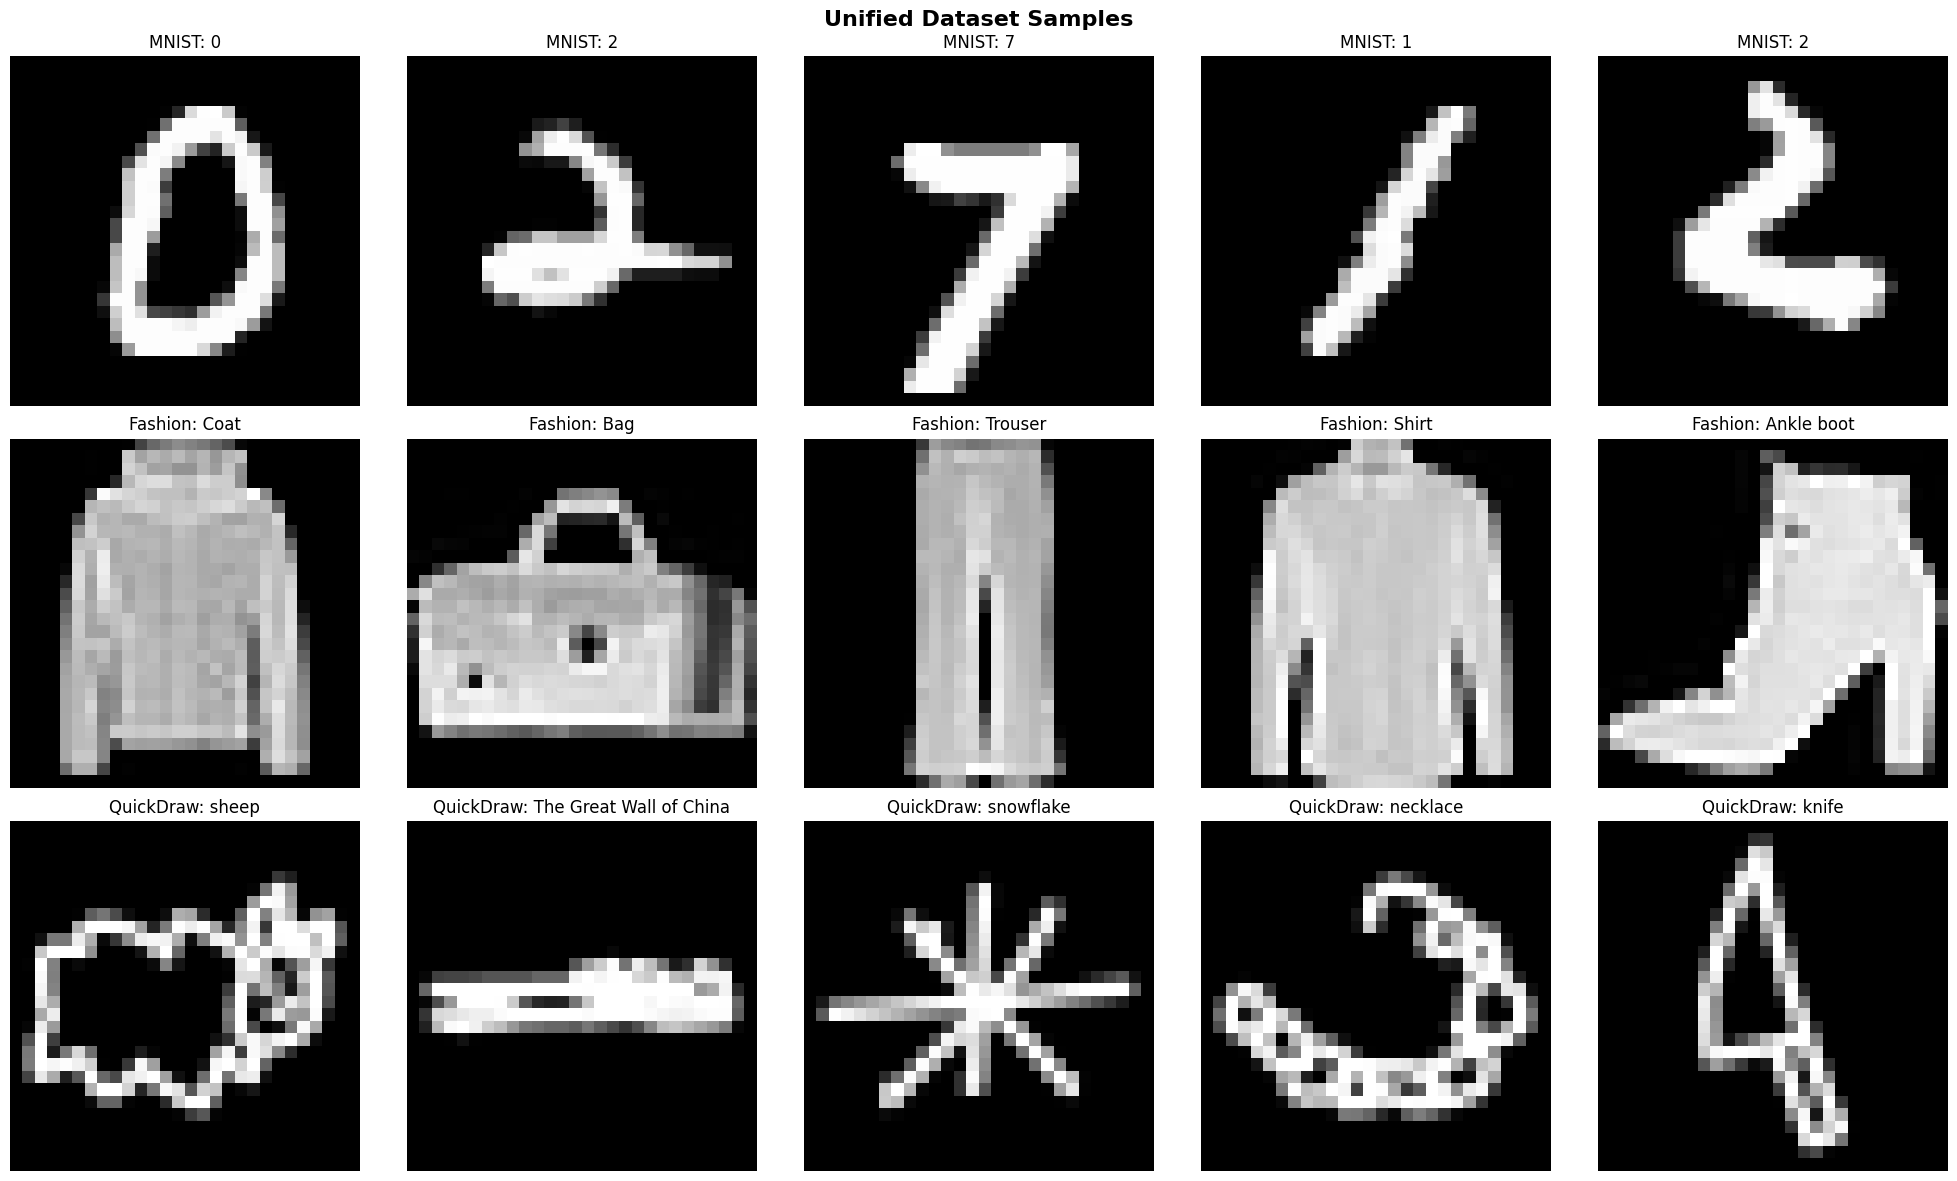

In [8]:
def visualize_dataset_samples(x_data, y_data, class_names, samples_per_type=5):
    """Visualize samples from each dataset type"""
    print("Visualizing dataset samples...")
    
    # Get labels from one-hot
    y_labels = np.argmax(y_data, axis=1)
    
    fig, axes = plt.subplots(3, samples_per_type, figsize=(20, 12))
    
    # MNIST samples (classes 0-9)
    print("Finding MNIST samples...")
    mnist_indices = np.where(y_labels < 10)[0]
    if len(mnist_indices) >= samples_per_type:
        selected_mnist = np.random.choice(mnist_indices, samples_per_type, replace=False)
        for i, idx in enumerate(selected_mnist):
            axes[0, i].imshow(x_data[idx].squeeze(), cmap='gray')
            axes[0, i].set_title(f'MNIST: {class_names[y_labels[idx]]}', fontsize=12)
            axes[0, i].axis('off')
    
    # Fashion-MNIST samples (classes 10-19)
    print("Finding Fashion-MNIST samples...")
    fashion_indices = np.where((y_labels >= 10) & (y_labels < 20))[0]
    if len(fashion_indices) >= samples_per_type:
        selected_fashion = np.random.choice(fashion_indices, samples_per_type, replace=False)
        for i, idx in enumerate(selected_fashion):
            axes[1, i].imshow(x_data[idx].squeeze(), cmap='gray')
            axes[1, i].set_title(f'Fashion: {class_names[y_labels[idx]]}', fontsize=12)
            axes[1, i].axis('off')
    
    # QuickDraw samples (classes 20+)
    print("Finding QuickDraw samples...")
    quickdraw_indices = np.where(y_labels >= 20)[0]
    if len(quickdraw_indices) >= samples_per_type:
        selected_quickdraw = np.random.choice(quickdraw_indices, samples_per_type, replace=False)
        for i, idx in enumerate(selected_quickdraw):
            axes[2, i].imshow(x_data[idx].squeeze(), cmap='gray')
            class_name = class_names[y_labels[idx]].replace('_', ' ')
            axes[2, i].set_title(f'QuickDraw: {class_name}', fontsize=12)
            axes[2, i].axis('off')
    
    plt.suptitle('Unified Dataset Samples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_dataset_samples(x_train, y_train, all_class_names)

In [9]:
def create_unified_cnn_model(num_classes, input_shape=(28, 28, 1)):
    """Create an enhanced CNN architecture for the unified dataset"""
    print(f"Creating CNN model for {num_classes} classes...")
    
    model = tf.keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_1'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_2'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.BatchNormalization(name='bn1'),
        layers.Dropout(0.25, name='dropout1'),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_1'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_2'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.BatchNormalization(name='bn2'),
        layers.Dropout(0.25, name='dropout2'),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_1'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_2'),
        layers.MaxPooling2D((2, 2), name='pool3'),
        layers.BatchNormalization(name='bn3'),
        layers.Dropout(0.25, name='dropout3'),
        
        # Fourth convolutional block (for handling complex QuickDraw features)
        layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_1'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_2'),
        layers.GlobalAveragePooling2D(name='global_avg_pool'),
        layers.Dropout(0.4, name='dropout4'),
        
        # Dense layers for classification
        layers.Dense(512, activation='relu', name='dense1'),
        layers.BatchNormalization(name='bn_dense1'),
        layers.Dropout(0.5, name='dropout_dense1'),
        
        layers.Dense(256, activation='relu', name='dense2'),
        layers.BatchNormalization(name='bn_dense2'),
        layers.Dropout(0.3, name='dropout_dense2'),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax', name='output')
    ])
    
    return model

# Create the model
model = create_unified_cnn_model(num_classes)

# Display model summary
print("\nModel Architecture:")
model.summary()

# Plot model architecture (optional)
try:
    tf.keras.utils.plot_model(
        model, 
        to_file='model_architecture.png', 
        show_shapes=True, 
        show_layer_names=True,
        rankdir='TB'
    )
    print("Model architecture diagram saved as 'model_architecture.png'")
except:
    print("Could not generate model architecture diagram")

Creating CNN model for 365 classes...


I0000 00:00:1759336670.088199      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759336670.088849      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 14, 14, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 7, 7, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 3, 3, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_2 (Conv2D)                │ (None, 3, 3, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense1 (BatchNormalization)  │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense1 (Dropout)        │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense2 (BatchNormalization)  │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,532,365 (5.85 MB)

 Trainable params: 1,530,381 (5.84 MB)

 Non-trainable params: 1,984 (7.75 KB)

Model architecture diagram saved as 'model_architecture.png'


In [10]:
def compile_model(model):
    """Compile the model with optimized settings for multi-class classification"""
    print("Compiling model...")
    
    # Use Adam optimizer with learning rate scheduling
    initial_learning_rate = 0.001
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=initial_learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )
    
    # Compile with appropriate metrics
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=10, name='top_10_accuracy')
        ]
    )
    
    print("Model compiled successfully!")
    return model

# Compile the model
model = compile_model(model)

Compiling model...
Model compiled successfully!


In [11]:
def setup_callbacks():
    """Setup training callbacks for optimal training"""
    print("Setting up training callbacks...")
    
    callbacks = [
        # Early stopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        
        # Reduce learning rate when plateau
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1,
            mode='min'
        ),
        
        # Save best model
        tf.keras.callbacks.ModelCheckpoint(
            'best_unified_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1,
            mode='max'
        ),
        
        # Learning rate logging
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch, lr: lr * 0.95 if epoch > 0 else lr,
            verbose=0
        )
    ]
    
    print(f"Setup {len(callbacks)} callbacks")
    return callbacks

# Setup callbacks
callbacks = setup_callbacks()

Setting up training callbacks...
Setup 4 callbacks


In [12]:
def train_model(model, x_train, y_train, x_val, y_val, callbacks, class_weights, epochs=25, batch_size=128):
    """Train the unified CNN model"""
    print("Starting model training...")
    print(f"Training samples: {x_train.shape[0]:,}")
    print(f"Validation samples: {x_val.shape[0]:,}")
    print(f"Batch size: {batch_size}")
    print(f"Max epochs: {epochs}")
    
    # Train the model
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1,
        shuffle=True
    )
    
    print("Training completed!")
    return history

# Train the model
training_history = train_model(
    model=model,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    callbacks=callbacks,
    class_weights=class_weights,
    epochs=25,
    batch_size=128
)

Starting model training...
Training samples: 664,000
Validation samples: 166,000
Batch size: 128
Max epochs: 25
Epoch 1/25


I0000 00:00:1759336708.031917     103 service.cc:148] XLA service 0x7e46f0002d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759336708.032836     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759336708.032857     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759336708.826436     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


   7/5188 ━━━━━━━━━━━━━━━━━━━━ 1:52 22ms/step - accuracy: 0.0019 - loss: 6.2492 - top_10_accuracy: 0.0318 - top_5_accuracy: 0.0109     

I0000 00:00:1759336717.356085     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5188/5188 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1502 - loss: 4.4116 - top_10_accuracy: 0.4486 - top_5_accuracy: 0.3465
Epoch 1: val_accuracy improved from -inf to 0.51316, saving model to best_unified_model.h5
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 103s 17ms/step - accuracy: 0.1503 - loss: 4.4114 - top_10_accuracy: 0.4486 - top_5_accuracy: 0.3466 - val_accuracy: 0.5132 - val_loss: 2.0027 - val_top_10_accuracy: 0.8519 - val_top_5_accuracy: 0.7814 - learning_rate: 0.0010
Epoch 2/25
5185/5188 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4634 - loss: 2.4828 - top_10_accuracy: 0.8248 - top_5_accuracy: 0.7439
Epoch 2: val_accuracy improved from 0.51316 to 0.59968, saving model to best_unified_model.h5
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 79s 15ms/step - accuracy: 0.4634 - loss: 2.4827 - top_10_accuracy: 0.8248 - top_5_accuracy: 0.7439 - val_accuracy: 0.5997 - val_loss: 1.6300 - val_top_10_accuracy: 0.8916 - val_top_5_accuracy: 0.8382 - learning_rate: 9.5000e-04
Epoch 3/25
5185/5188 ━━━━━━━━━━

Plotting training history...


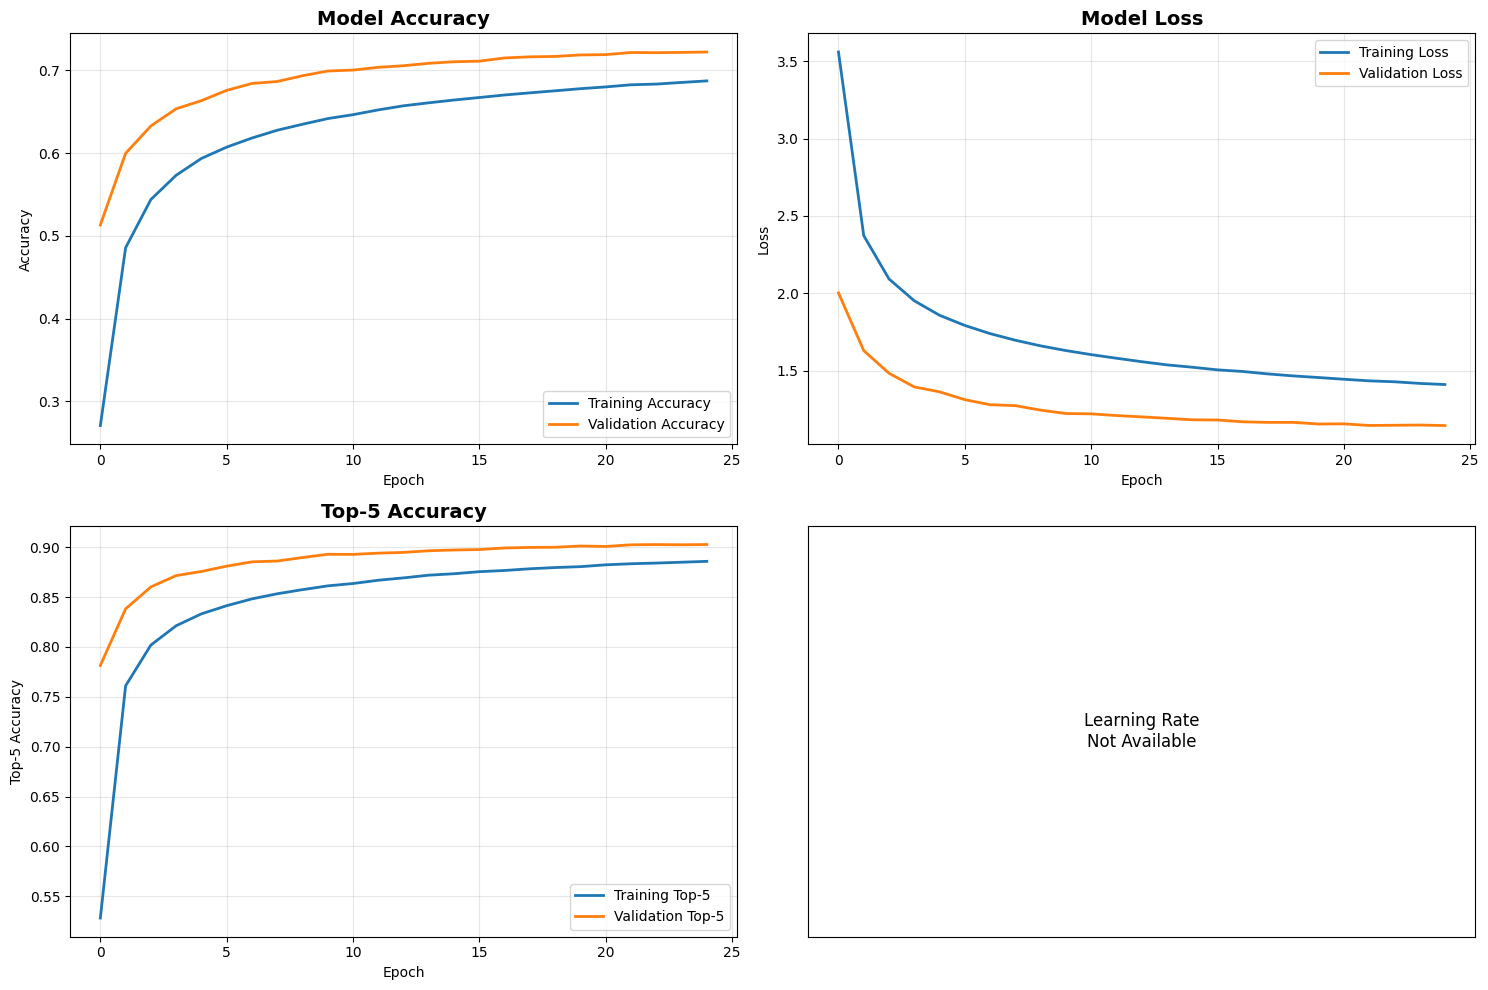

Evaluating final model...

Final Validation Results:
Loss: 1.1457
Accuracy: 0.7222 (72.22%)
Top-5 Accuracy: 0.9027 (90.27%)
Top-10 Accuracy: 0.9340 (93.40%)


In [13]:
def plot_training_history(history):
    """Plot training history"""
    print("Plotting training history...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy plot
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Top-5 Accuracy plot
    axes[1, 0].plot(history.history['top_5_accuracy'], label='Training Top-5', linewidth=2)
    axes[1, 0].plot(history.history['val_top_5_accuracy'], label='Validation Top-5', linewidth=2)
    axes[1, 0].set_title('Top-5 Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Top-5 Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning rate plot
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'], linewidth=2, color='red')
        axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Learning Rate\nNot Available', 
                       ha='center', va='center', fontsize=12, transform=axes[1, 1].transAxes)
        axes[1, 1].set_xticks([])
        axes[1, 1].set_yticks([])
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, x_val, y_val):
    """Evaluate the final model"""
    print("Evaluating final model...")
    
    # Evaluate on validation set
    val_results = model.evaluate(x_val, y_val, verbose=0)
    
    print(f"\nFinal Validation Results:")
    print(f"Loss: {val_results[0]:.4f}")
    print(f"Accuracy: {val_results[1]:.4f} ({val_results[1]*100:.2f}%)")
    print(f"Top-5 Accuracy: {val_results[2]:.4f} ({val_results[2]*100:.2f}%)")
    print(f"Top-10 Accuracy: {val_results[3]:.4f} ({val_results[3]*100:.2f}%)")
    
    return val_results

# Plot training history and evaluate
plot_training_history(training_history)
final_results = evaluate_model(model, x_val, y_val)

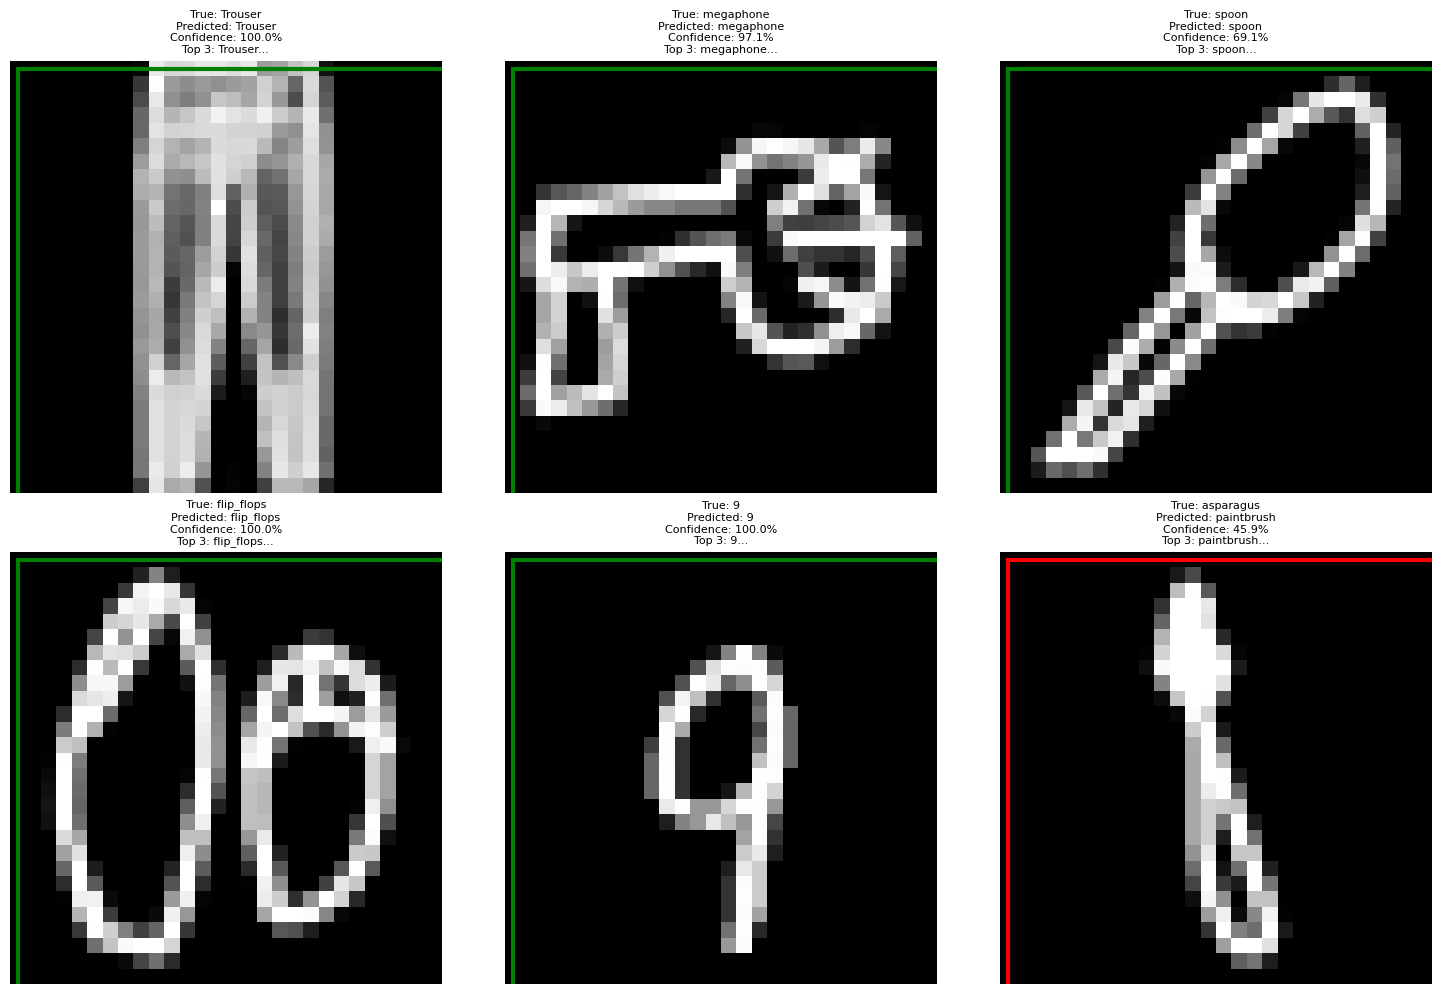

In [14]:
def test_predictions(model, x_data, y_true, class_names, num_samples=6):
    """Test model predictions on random samples"""
    
    # Get random images to test
    indices = np.random.choice(len(x_data), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        # Get model's prediction for this image
        single_image = np.expand_dims(x_data[idx], axis=0)  # Add batch dimension
        pred_probs = model.predict(single_image, verbose=0)[0]  # Get probabilities
        
        # Find the classes with highest probabilities
        pred_class = np.argmax(pred_probs)  # Model's best guess
        true_class = np.argmax(y_true[idx])  # Actual correct answer
        confidence = pred_probs[pred_class]  # How confident the model is
        
        # Get top 3 predictions
        top3_indices = np.argsort(pred_probs)[-3:][::-1]  # 3 highest probabilities
        top3_probs = pred_probs[top3_indices]
        top3_names = [class_names[j] for j in top3_indices]
        
        # Display the image
        axes[i].imshow(x_data[idx].squeeze(), cmap='gray')
        
        # Create informative title
        title = f"True: {class_names[true_class]}\n"
        title += f"Predicted: {class_names[pred_class]}\n"
        title += f"Confidence: {confidence:.1%}\n"
        title += f"Top 3: {top3_names[0][:10]}..."
        
        axes[i].set_title(title, fontsize=8)
        axes[i].axis('off')
        
        # Color the border based on correctness
        if pred_class == true_class:
            # Green border for correct predictions
            axes[i].add_patch(plt.Rectangle((0, 0), 28, 28, fill=False, 
                                          edgecolor='green', linewidth=3))
        else:
            # Red border for wrong predictions
            axes[i].add_patch(plt.Rectangle((0, 0), 28, 28, fill=False, 
                                          edgecolor='red', linewidth=3))
    
    plt.tight_layout()
    plt.show()

# Test the model on individual images
test_predictions(model, x_val, y_val, all_class_names)

In [15]:
def analyze_performance_by_dataset(model, x_val, y_val, all_class_names):
    """Analyze how well the model performs on each dataset type"""
    print("Analyzing performance by dataset type...")
    
    # Get predictions for all validation data
    y_pred_probs = model.predict(x_val, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)
    
    # Separate by dataset type
    mnist_mask = (y_true >= 0) & (y_true <= 9)
    fashion_mask = (y_true >= 10) & (y_true <= 19)
    quickdraw_mask = y_true >= 20
    
    # Calculate accuracy for each dataset
    mnist_accuracy = np.mean(y_pred[mnist_mask] == y_true[mnist_mask])
    fashion_accuracy = np.mean(y_pred[fashion_mask] == y_true[fashion_mask])
    quickdraw_accuracy = np.mean(y_pred[quickdraw_mask] == y_true[quickdraw_mask])
    
    # Count samples in each category
    mnist_count = np.sum(mnist_mask)
    fashion_count = np.sum(fashion_mask)
    quickdraw_count = np.sum(quickdraw_mask)
    
    print(f"\nPerformance by Dataset Type:")
    print(f"{'Dataset':<15} {'Samples':<10} {'Accuracy':<12} {'Performance'}")
    print("-" * 50)
    print(f"{'MNIST':<15} {mnist_count:<10} {mnist_accuracy:<12.1%} {'🟢 Excellent' if mnist_accuracy > 0.95 else '🟡 Good' if mnist_accuracy > 0.85 else '🔴 Needs work'}")
    print(f"{'Fashion-MNIST':<15} {fashion_count:<10} {fashion_accuracy:<12.1%} {'🟢 Excellent' if fashion_accuracy > 0.90 else '🟡 Good' if fashion_accuracy > 0.80 else '🔴 Needs work'}")
    print(f"{'QuickDraw':<15} {quickdraw_count:<10} {quickdraw_accuracy:<12.1%} {'🟢 Excellent' if quickdraw_accuracy > 0.80 else '🟡 Good' if quickdraw_accuracy > 0.70 else '🔴 Needs work'}")
    
    return {
        'mnist': {'accuracy': mnist_accuracy, 'count': mnist_count},
        'fashion': {'accuracy': fashion_accuracy, 'count': fashion_count},
        'quickdraw': {'accuracy': quickdraw_accuracy, 'count': quickdraw_count}
    }

# Analyze performance by dataset
performance_analysis = analyze_performance_by_dataset(model, x_val, y_val, all_class_names)

Analyzing performance by dataset type...
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step

Performance by Dataset Type:
Dataset         Samples    Accuracy     Performance
--------------------------------------------------
MNIST           14000      99.0%        🟢 Excellent
Fashion-MNIST   14000      88.0%        🟡 Good
QuickDraw       138000     67.9%        🔴 Needs work


Creating confusion matrix for sample classes...


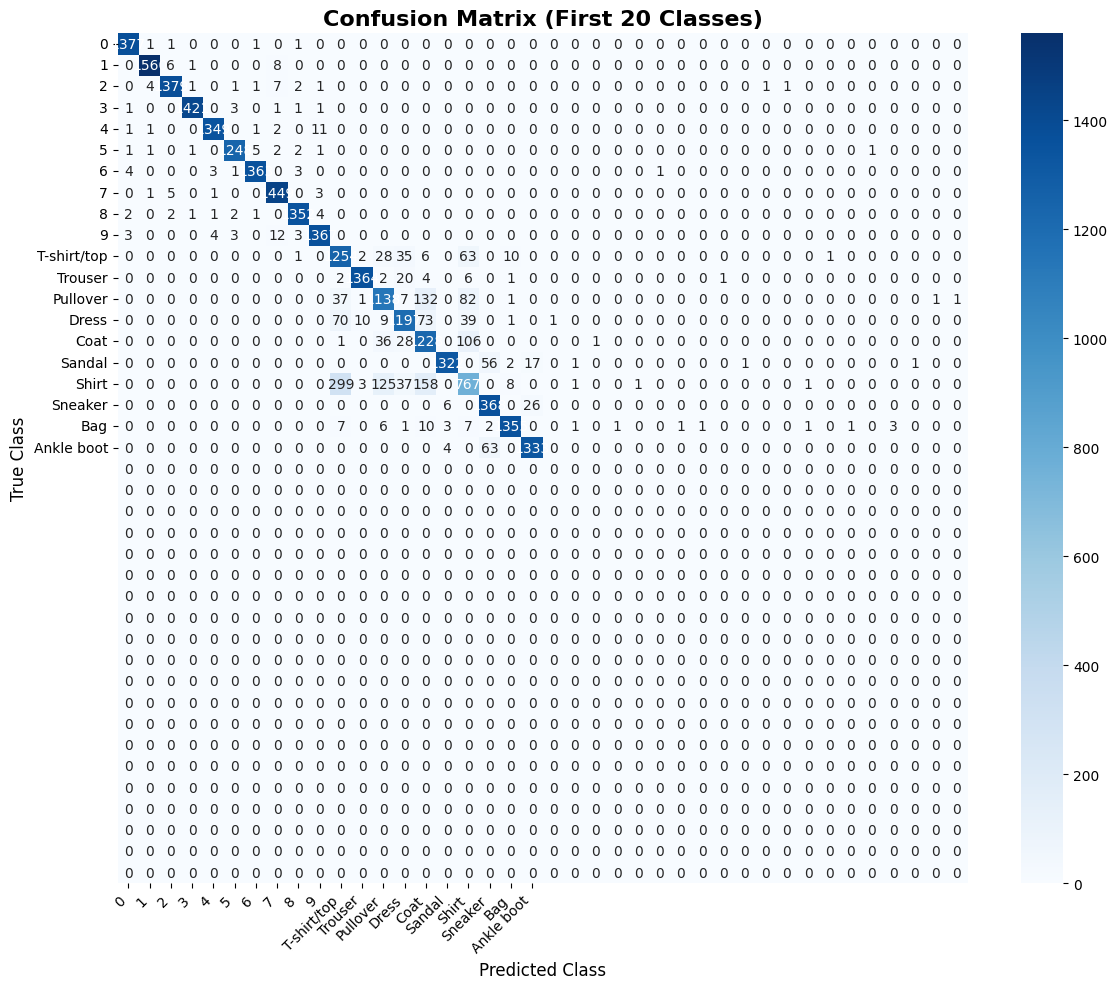

In [16]:
def create_confusion_matrix_sample(model, x_val, y_val, class_names, sample_classes=20):
    """Create a confusion matrix for a sample of classes"""
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    print("Creating confusion matrix for sample classes...")
    
    # Get predictions
    y_pred_probs = model.predict(x_val, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)
    
    # Select first 20 classes for visualization (to keep it readable)
    mask = y_true < sample_classes
    y_true_sample = y_true[mask]
    y_pred_sample = y_pred[mask]
    
    # Create confusion matrix
    cm = confusion_matrix(y_true_sample, y_pred_sample)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=class_names[:sample_classes],
                yticklabels=class_names[:sample_classes])
    plt.title('Confusion Matrix (First 20 Classes)', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return cm

# Create confusion matrix
confusion_matrix = create_confusion_matrix_sample(model, x_val, y_val, all_class_names)

In [19]:
def save_model_and_results(model, history, performance_analysis, all_class_names):
    """Save the trained model and all related information"""
    print("Saving model and results...")
    
    # Save the trained model
    model.save('unified_cnn_model.h5')
    print("✅ Model saved as 'unified_cnn_model.h5'")
    
    # Save model weights separately (for loading flexibility) - FIXED EXTENSION
    model.save_weights('unified_cnn_weights.weights.h5')
    print("✅ Model weights saved as 'unified_cnn_weights.weights.h5'")
    
    # Save class names
    with open('class_names.txt', 'w') as f:
        for i, class_name in enumerate(all_class_names):
            f.write(f"{i}: {class_name}\n")
    print("✅ Class names saved as 'class_names.txt'")
    
    # Save training history
    import pickle
    with open('training_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
    print("✅ Training history saved as 'training_history.pkl'")
    
    # Save final results summary
    final_results = {
        'model_architecture': 'Unified CNN',
        'total_classes': len(all_class_names),
        'datasets_used': ['MNIST', 'Fashion-MNIST', 'QuickDraw'],
        'training_samples': len(x_train),
        'validation_samples': len(x_val),
        'final_validation_accuracy': float(max(history.history['val_accuracy'])),  # Use max val_accuracy
        'training_epochs': len(history.history['accuracy']),
        'best_validation_accuracy': float(max(history.history['val_accuracy'])),
        'model_size_mb': os.path.getsize('unified_cnn_model.h5') / (1024*1024)
    }
    
    import json
    with open('model_results.json', 'w') as f:
        json.dump(final_results, f, indent=2)
    print("✅ Results summary saved as 'model_results.json'")
    
    # Print summary
    print(f"\n{'='*50}")
    print("MODEL TRAINING COMPLETE!")
    print(f"{'='*50}")
    print(f"📊 Total Classes: {final_results['total_classes']}")
    print(f"🎯 Final Accuracy: {final_results['best_validation_accuracy']:.1%}")
    print(f"📁 Model Size: {final_results['model_size_mb']:.1f} MB")
    print(f"⏱️ Training Epochs: {final_results['training_epochs']}")
    print(f"{'='*50}")

# Save everything
save_model_and_results(model, training_history, performance_analysis, all_class_names)

Saving model and results...
✅ Model saved as 'unified_cnn_model.h5'
✅ Model weights saved as 'unified_cnn_weights.weights.h5'
✅ Class names saved as 'class_names.txt'
✅ Training history saved as 'training_history.pkl'
✅ Results summary saved as 'model_results.json'

MODEL TRAINING COMPLETE!
📊 Total Classes: 365
🎯 Final Accuracy: 72.2%
📁 Model Size: 17.7 MB
⏱️ Training Epochs: 25


In [20]:
# In a new Kaggle cell
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
pandas-gbq 0.29.1 requires google-api-core<3.0.0,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
plot

In [32]:
import tensorflow as tf
import tensorflowjs as tfjs
import numpy as np

# Load the original model
original_model = tf.keras.models.load_model('/kaggle/working/unified_cnn_model.h5')
print("Original model loaded")

# Get the model architecture and weights
config = original_model.get_config()
weights = original_model.get_weights()

print("Model config and weights extracted")

# Create a completely new model with explicit input layer
new_model = tf.keras.Sequential()

# Add explicit input layer with proper configuration
new_model.add(tf.keras.layers.Input(
    shape=(28, 28, 1), 
    batch_size=None,
    name='input_layer'
))

# Add all the other layers manually (skip the problematic first layer)
for i, layer_config in enumerate(config['layers'][1:], 1):  # Skip first layer
    layer_type = layer_config['class_name']
    layer_params = layer_config['config']
    
    print(f"Adding layer {i}: {layer_type}")
    
    if layer_type == 'Conv2D':
        new_model.add(tf.keras.layers.Conv2D(
            filters=layer_params['filters'],
            kernel_size=layer_params['kernel_size'],
            strides=layer_params['strides'],
            padding=layer_params['padding'],
            activation=layer_params['activation']
        ))
    elif layer_type == 'MaxPooling2D':
        new_model.add(tf.keras.layers.MaxPooling2D(
            pool_size=layer_params['pool_size'],
            strides=layer_params['strides'],
            padding=layer_params['padding']
        ))
    elif layer_type == 'BatchNormalization':
        new_model.add(tf.keras.layers.BatchNormalization())
    elif layer_type == 'Dropout':
        new_model.add(tf.keras.layers.Dropout(layer_params['rate']))
    elif layer_type == 'GlobalAveragePooling2D':
        new_model.add(tf.keras.layers.GlobalAveragePooling2D())
    elif layer_type == 'Flatten':
        new_model.add(tf.keras.layers.Flatten())
    elif layer_type == 'Dense':
        new_model.add(tf.keras.layers.Dense(
            units=layer_params['units'],
            activation=layer_params['activation']
        ))

print("New model architecture created")

# Set the weights
try:
    new_model.set_weights(weights)
    print("✅ Weights transferred successfully")
except Exception as e:
    print(f"❌ Weight transfer failed: {e}")
    # Try layer by layer weight transfer
    print("Trying layer-by-layer weight transfer...")
    for i, (new_layer, weight) in enumerate(zip(new_model.layers[1:], weights)):
        try:
            if len(original_model.layers[i].get_weights()) > 0:
                new_layer.set_weights(original_model.layers[i].get_weights())
                print(f"✅ Layer {i} weights transferred")
        except Exception as layer_e:
            print(f"❌ Layer {i} failed: {layer_e}")

# Test the model
print("Testing new model...")
test_input = np.random.random((1, 28, 28, 1)).astype('float32')
test_output = new_model.predict(test_input, verbose=0)
print(f"Test prediction shape: {test_output.shape}")
print(f"Test prediction sum: {test_output.sum():.3f}")

# Save and convert
print("Converting to TensorFlow.js...")
new_model.save('/kaggle/working/fixed_model.h5')

# Convert using command line
!mkdir -p /kaggle/working/tfjs_final
!tensorflowjs_converter --input_format keras /kaggle/working/fixed_model.h5 /kaggle/working/tfjs_final/

print("✅ Conversion completed!")

# Check files
!ls -la /kaggle/working/tfjs_final/

Original model loaded
Model config and weights extracted
Adding layer 1: Conv2D
Adding layer 2: Conv2D
Adding layer 3: MaxPooling2D
Adding layer 4: BatchNormalization
Adding layer 5: Dropout
Adding layer 6: Conv2D
Adding layer 7: Conv2D
Adding layer 8: MaxPooling2D
Adding layer 9: BatchNormalization
Adding layer 10: Dropout
Adding layer 11: Conv2D
Adding layer 12: Conv2D
Adding layer 13: MaxPooling2D
Adding layer 14: BatchNormalization
Adding layer 15: Dropout
Adding layer 16: Conv2D
Adding layer 17: Conv2D
Adding layer 18: GlobalAveragePooling2D
Adding layer 19: Dropout
Adding layer 20: Dense
Adding layer 21: BatchNormalization
Adding layer 22: Dropout
Adding layer 23: Dense
Adding layer 24: BatchNormalization
Adding layer 25: Dropout
Adding layer 26: Dense
New model architecture created
✅ Weights transferred successfully
Testing new model...
Test prediction shape: (1, 365)
Test prediction sum: 1.000
Converting to TensorFlow.js...
2025-10-01 18:21:33.553347: E external/local_xla/xla/s

In [26]:
# Create a zip file with all model files for easy download
import zipfile

def create_model_zip():
    zip_path = '/kaggle/working/tfjs_model.zip'
    
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        # Add all model files
        for root, dirs, files in os.walk('/kaggle/working/tfjs_model'):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, '/kaggle/working/')
                zipf.write(file_path, arcname)
        
        # Add class names file (create it if you don't have it)
        with open('/kaggle/working/class_names.txt', 'w') as f:
            class_names = [
                "0", "1", "2", "3", "4", "5", "6", "7", "8", "9",  # MNIST
                "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot",  # Fashion-MNIST
                # Add all your QuickDraw classes here (copy from your attachment)
                "aircraft_carrier", "airplane", "alarm_clock", "ambulance", "angel",
                # ... (I'll provide the complete list in the next step)
            ]
            for i, name in enumerate(class_names):
                f.write(f"{i}: {name}\n")
        
        zipf.write('/kaggle/working/class_names.txt', 'class_names.txt')
    
    print(f"✅ Model package created: {zip_path}")
    print("📥 Download this file from Kaggle output section")

create_model_zip()

✅ Model package created: /kaggle/working/tfjs_model.zip
📥 Download this file from Kaggle output section


In [40]:
import os

# Remove a single zip file
zip_file_to_delete = '/kaggle/working/fixed_model.h5'

if os.path.exists(zip_file_to_delete):
    os.remove(zip_file_to_delete)
    print(f"✅ Deleted zip file: {zip_file_to_delete}")
else:
    print(f"⚠️ Zip file not found: {zip_file_to_delete}")

✅ Deleted zip file: /kaggle/working/fixed_model.h5
